For this classification exercise, I followed Chapter 3 from the '**Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow**' textbook by Aurélien Géron.

Reference:
Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems. O'Reilly Media, 2019. 

In [152]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# For binary classifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, precision_recall_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# For multiclass classifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler

# For multilabel classifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Import MNIST dataset
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [30]:
X = mnist['data']
y = mnist['target'].astype(np.uint8) # Convert labels from strings to integers
print(X.shape) 
print(y.shape)

(70000, 784)
(70000,)


The data set contains 70,000 images and each image has 784 features, where each feature is a pixel intensity (0 = white, 255 = black). We can use matplotlib to organize the 784 features of an instance into a 28 x 28 grid to display the number.

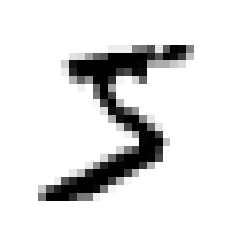

In [130]:
digit = X.loc[0]
digit_image = digit.values.reshape(28,28)

plt.imshow(digit_image, cmap = "binary")
plt.axis("off")
plt.show()

And the corresponding label is:

In [31]:
y[0]

5

#### Split Data into Train and Test Sets
This dataset has already been split, the first 60,000 instances are training and the last 10,000 are test. Also, the training set is already shuffled, which helps avoid problems with models that are sensitive to the order of training samples.

In [32]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## *Binary Classifer*
To start off, we'll start by training a classifer to classify whether a digit is '5' or 'not 5'.
- SGD, Random Forest, and naive Bayes can be binary/multinomial classifiers
- Logistic Regression, and SVM are strictly binary classifiers

In [35]:
# Create new target vectors -- True = 5, False = not 5
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

## A. Stochastic Gradient Descent (SGD) Classifier
- Handles large datasets efficiently: deals with one training instance at a time

In [59]:
sgd_classif = SGDClassifier(random_state = 42)
sgd_classif.fit(X_train.values, y_train_5)

SGDClassifier(random_state=42)

Test the model on a digit that we already know is a 5, the result should be 'True'.

In [54]:
sgd_classif.predict([digit])

array([ True])

### Evaluate Performance
***Method 1***: Cross-Validation

In [61]:
cross_val_score(sgd_classif, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

Calculate a model baseline for accuracy to compare the cross-validation results to.

In [64]:
class Not5Classifier(BaseEstimator):
    
    def fit(self, X, y = None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [65]:
not_5_classif = Not5Classifier()
cross_val_score(not_5_classif, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

This naive classifer already performs with over 90% accuracy, which makes sense since if you always guess that an image is 'not 5', then you'll be right approximately 90% of the time. This is why accuracy is not ideal to evaluate classifiers, especially when the dataset is skewed (i.e. when class sizes are uneven).

***Method 2***: Confusion Matrix

In [71]:
# cross_val_predict() returns clean predictions for each test fold 
y_train_pred = cross_val_predict(sgd_classif, X_train, y_train_5, cv = 3)

cnfsn_mat = confusion_matrix(y_train_5, y_train_pred) # Input targets and predictions
cnfsn_mat

array([[53892,   687],
       [ 1891,  3530]])

In [74]:
# Precision = TP / (TP + FP) -- can use precision_score()
precision = cnfsn_mat[1,1]/(cnfsn_mat[1,1] + cnfsn_mat[0,1])

# Recall = TP / (TP + FN) aka. sensitivity, true positive rate -- can use recall_score()
recall = cnfsn_mat[1,1]/(cnfsn_mat[1,1] + cnfsn_mat[1,0])

# F1 Score = 2(precision*recall / precision+recall) -- can use f1_score()
# This metric favours classifiers with similar recall and precision (not always desirable)
F1 = 2*((precision*recall)/(precision+recall))

print("Precision score = %0.3f" % precision)
print("Recall score = %0.3f" % recall)
print("F1 Score = %0.3f" % F1)

Precision score = 0.837
Recall score = 0.651
F1 Score = 0.733


This means that our model to detect 5s is correct 83.7% of the time, and only detects 65.1% of the 5s. There will always be a precision-recall tradeoff; increasing precision reduces recall and vice versa.

#### Precision-Recall Tradeoff
- Want to find threshold that optimizes precision and recall.
- SGDClassifier() has a default threshold of 0.
- Increasing the threshold increases precision and decreases recall, and vice versa.

We'll test this on a single digit which we know is a 5:

In [88]:
# decision_function() returns a score for each instance
y_scores = sgd_classif.decision_function([digit])
threshold = 0 # Set to default
y_digit_pred = (y_scores > threshold)
y_digit_pred

array([ True])

In [89]:
threshold = 8000
y_digit_pred = (y_scores > threshold)
y_digit_pred

array([False])

This shows that increasing the threshold does in fact decrease recall, i.e. classifier detects the 5 as a 5 when threshold = 0 but not when threshold = 8000.

To decide which threshold to use, we can use cross_cal_predict() to get scores of all instances in the training set, then feed the scores to precision_recall_curve() to calculate precision and recall for all possible thresholds.

In [94]:
# Set method to "decision_function" to return scores instead of label predictions
y_scores = cross_val_predict(sgd_classif, X_train, y_train_5, cv = 3, method = "decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

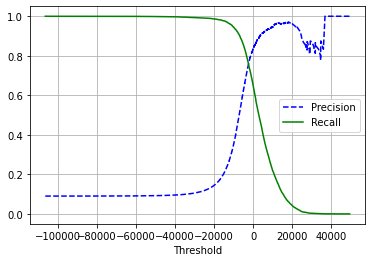

In [103]:
# Create plot
plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
plt.legend(loc = "center right")
plt.xlabel("Threshold")
plt.grid()
plt.show()

To make the decision it might be more helpful to look at a graph of precision vs. recall:

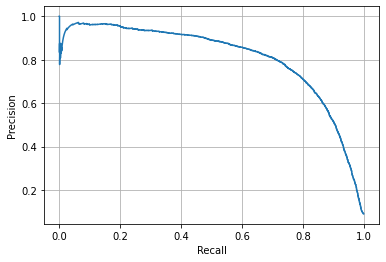

In [104]:
plt.plot(recalls[:-1], precisions[:-1])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()

This plot shows that precision starts to fall faster at around 80% recall. Can choose a precision/recall just before this drop, but it depends on the project. Suppose that for this project we want a precision of 90%.

In [112]:
# Find threshold that gives at least 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
                                              
# Make predictions on training set
y_train_pred_90 = (y_scores >= threshold_90_precision)

# Check precision and recall of predictions
print("Threshold = %f" % threshold_90_precision)
print("Precision score = %f" % precision_score(y_train_5, y_train_pred_90))                                         
print("Recall score = %f" % recall_score(y_train_5, y_train_pred_90))                                           

Threshold = 3370.019499
Precision score = 0.900035
Recall score = 0.479985


Thus, using a threshold of 3370 will give us a 90% precision classifier.

Similar to the precision/recall curve, we can also look at the **ROC curve**. It plots *true positive rate* VS. *false positive rate*, i.e. *sensitivity* (recall) VS. 1 - *specificity*.

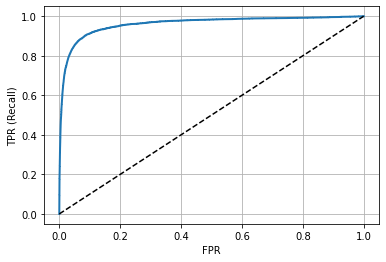

In [115]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

plt.plot(fpr, tpr, linewidth = 2)
plt.plot([0,1], [0,1], 'k--') # Add diagonal line
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
plt.grid()
plt.show()

We can evaluate the performance of the classifier by calculating the area under the ROC curve, using the function roc_auc_score(). 

In [118]:
auc_score = roc_auc_score(y_train_5, y_scores)
print("This classifier has an ROC AUC score of %f" % auc_score)

This classifier has an ROC AUC score of 0.960494


This score is very close to 1, meaning it is close to being a perfect classifer. A naive/random classifier would have a score closer to 0.5.

## B. Random Forest Classifier

In [78]:
forest_classif = RandomForestClassifier(random_state = 42)

# Use predict_proba() method
# Output is a 2d array:
    # Rows are instances, columns are probabilities that a given instance belongs to a given class (i.e. '5' or 'not 5')
y_prob_forest = cross_val_predict(forest_classif, X_train, y_train_5, cv = 3, method = "predict_proba")

### Evaluate Performance

In [82]:
# Need labels and scores (use positive class probabilities for scores)
y_scores_forest = y_prob_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

We'll plot this ROC curve along with the ROC curve from the SGD classifier to compare models.

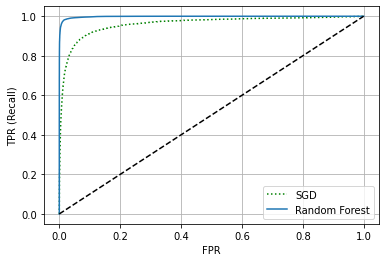

In [120]:
# Recall -- 'fpr' and 'tpr' are the false and true positive rates of the SGD classifier
plt.plot(fpr, tpr, "g:", label = "SGD")
plt.plot(fpr_forest, tpr_forest, label = "Random Forest")
plt.plot([0,1], [0,1], 'k--') # Add diagonal line
plt.legend(loc = "lower right")
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
plt.grid()
plt.show()

From this plot it is clear that the area under the ROC curve for the Random Forest classifier is greater than that of the SGD classifer. Thus, it is a better classifier.

# *Multiclass Classifer*

We will create a system of binary classifiers to classify the digits into 10 classes. In particular, we will train a SVM classifier for every pair of digits (i.e. one to classify 0s and 1s, one for 0s and 2s, and so on) which is a called the one-vs-one (OvO) strategy. This method works best for SVM classifiers since they perform better on smaller training sets, and OvO trains many classifiers on small training sets. Note: the OvR strategy is preffered for most other binary classifers.

## A. SVN Classifier (OvO Strategy)

In [123]:
svm_classif = SVC()
# Train SVC on original target classes with digits 0-9
# sklearn automatically chooses OvO strategy when using SVC()
    # i.e. trained (9*8)/2 = 45 binary classifiers, got their decision scores for the image,
    # then selected the class that 'won' the most duels.
    # Each classifier only uses instances from the training set corresponding to its two classes.
svm_classif.fit(X_train.values, y_train)
svm_classif.predict([digit])

array([5], dtype=uint8)

In [124]:
digit_scores = svm_classif.decision_function([digit])
digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

We already know the digit is a 5, and indeed, the highest decision score corresponds to class 5.

## B. SGD Classifier
- Can classify instances into multiple classes without OvO or OvR.

In [128]:
sgd_classif.fit(X_train.values, y_train)
sgd_classif.predict([digit])

array([3], dtype=uint8)

In [129]:
sgd_classif.decision_function([digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

### Evaluate Model

In [132]:
cross_val_score(sgd_classif, X_train.values, y_train, cv = 3, scoring = "accuracy")

array([0.87365, 0.85835, 0.8689 ])

Calculate a model baseline for accuracy to compare the cross-validation results to.

In [136]:
class RandomClassifier(BaseEstimator):
    
    def fit(self, X, y = None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [137]:
random_classif = RandomClassifier()
cross_val_score(random_classif, X_train, y_train, cv = 3, scoring = "accuracy")

array([0.0997 , 0.0965 , 0.09995])

Using a naive/random classifier, we'd get an accuracy score of around 10%. This shows that an accuracy score of ~85% for our SGD classifier is a pretty good score. We can try scaling the inputs to increase accuracy.

In [139]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values.astype(np.float64))
cross_val_score(sgd_classif, X_train_scaled, y_train, cv = 3, scoring = "accuracy")

array([0.8983, 0.891 , 0.9018])

### Error Analysis

#### Confusion Matrix

In [141]:
# Make predictions
y_train_pred = cross_val_predict(sgd_classif, X_train_scaled, y_train, cv = 3)

# Compute confusion matrix
conf_mat = confusion_matrix(y_train, y_train_pred)
conf_mat

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

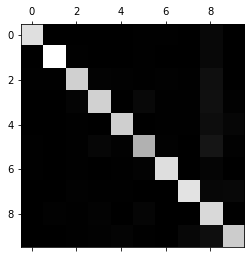

In [142]:
plt.matshow(conf_mat, cmap = plt.cm.gray)
plt.show()

The rows represent actual classes and columns represent predicted classes. The light shaded squares on the diagonal indicates that most images were classified correctly. The square corresponding to 5s looks very slightly darker, which suggests that either there were less images of 5s in the dataset or that the classifier doesn't perform as well on 5s, or both.

Normalize matrix to visualize errors:

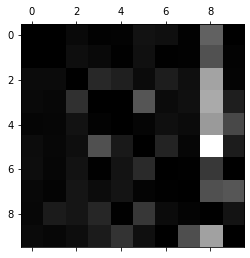

In [151]:
row_sums = conf_mat.sum(axis = 1, keepdims = True)

# Normalize confusion matrix by dividing the entries of each row by the row sums (i.e. number of images in that class)
norm_conf_mat = conf_mat / row_sums
# Set diagonal entries to be 0
np.fill_diagonal(norm_conf_mat, 0)

# Plot new matrix
plt.matshow(norm_conf_mat, cmap = plt.cm.gray)
plt.show()

Since the column for 8 has a lot of light shaded squares, we can tell that many images are being misclassified as 8. The row for 8 is fairly dark, so 8s are generally classified correctly. It also looks like there is some misclassification between 3s and 5s (both ways). This happens because 3s and 5s differ by only a few pixels and SGD classifiers are linear, meaning it simply sums up the weighted pixel intensities to get a score for each class.

So a next step would be to reduce the amount of false 8s. To do this, one can:
- Gather more training data of digits that look like 8, but aren't.
- Write algorithm to distinguish digits that look like 8 by counting the number of closed loops.
- Preprocss images to make patterns (e.g. closed loops) stand out more.

To reduce misclassification between 3s and 5s, one can:
- Preprocess images so that they're centered and not rotated.